In [91]:
import mne
import os
import os.path as osp

import pandas as pd
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pyriemann.spatialfilters import Xdawn
import numpy as np
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace
from pyriemann.estimation import XdawnCovariances
from pyriemann.estimation import Covariances

import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
# from filter.fbcsp import fbcsp

from numpy.random import seed

import winsound
import time

mne.set_log_level(verbose="Warning") # set all the mne verbose to warning
seed(2002012)

In [71]:
init_path = "C:\\Users\Dtrocell\Documents\ML\Big dataset\signal"
#init_path = "\\\\bor-nas1.bordeaux.inria.fr\potiocdata\BCI\\2022 BCI OPEN DATA\BCI Database Signals - Stim Clean\Signals"
files_dir=os.listdir(init_path)[1:4]
participant_dir= [os.listdir(osp.join(init_path,files_dir[i])) for i in range(len(files_dir))]
print("you have succesfuly acces to the directory : ",init_path)

you have succesfuly acces to the directory :  C:\Users\Dtrocell\Documents\ML\Big dataset\signal


In [72]:
participant_dir[0].remove("A59")
participant_dir[0].remove("A40")
#participant_dir[0].remove("A1") # in session 1 the training it's stop befored ( provoqued a bug in rest because there is no end of trial event)
# participant_dir[0].remove("A17") # Not have 40 events in one session
# participant_dir[0].remove("A22") # Not have 40 events in one session

In [73]:
def debug_stim(dic_data):
    for key in dic_data.keys():

        indice = np.where( dic_data[key].annotations.description == "32769")[0][0]
        if indice != 0 :
            if indice == 3 :
                dic_data[key].annotations.description = dic_data[key].annotations.description[indice:]
                dic_data[key].annotations.onset =dic_data[key].annotations.onset[1:-(indice-1)]
                dic_data[key].annotations.duration =dic_data[key].annotations.duration[1:-(indice-1)]
                dic_data[key].annotations.ch_names =dic_data[key].annotations.ch_names[1:-(indice-1)]
            else :
                dic_data[key].annotations.description = dic_data[key].annotations.description[indice:]
                dic_data[key].annotations.onset =dic_data[key].annotations.onset[:-indice]
                dic_data[key].annotations.duration =dic_data[key].annotations.duration[:-indice]
                dic_data[key].annotations.ch_names =dic_data[key].annotations.ch_names[:-indice]
    return dic_data

def collect_data(files_dir, participant_dir):
    dic_data_train ={}
    dic_data_test ={}
    for i in range(len(files_dir)):
        for j in range(len(participant_dir[i])):
            #Train dataset
            dic_data_train[participant_dir[i][j]+"_1"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R1_acquisition.gdf"), verbose="CRITICAL")
            dic_data_train[participant_dir[i][j]+"_2"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R2_acquisition.gdf"), verbose="CRITICAL")

            #Test dataset
            dic_data_test[participant_dir[i][j]+"_3"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R3_onlineT.gdf"), verbose="CRITICAL")
            dic_data_test[participant_dir[i][j]+"_4"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R4_onlineT.gdf"), verbose="CRITICAL")
            try : # allow to manage the one where there is no _5 and _6 files
                dic_data_test[participant_dir[i][j]+"_5"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R5_onlineT.gdf"), verbose="CRITICAL")
            except FileNotFoundError:
                pass

            try :
                dic_data_test[participant_dir[i][j]+"_6"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R6_onlineT.gdf"), verbose="CRITICAL")
            except FileNotFoundError:
                pass

    # dic_data_test= debug_stim(dic_data_test)
    # dic_data_train =debug_stim(dic_data_train)

    return dic_data_train, dic_data_test

In [74]:
print("START extraction data")
dic_data_train,dic_data_test=  collect_data(files_dir, participant_dir)
print("extraction data DONE")


START extraction data
extraction data DONE


Stimulation code
left =769
right = 770
end of trial =800

In [75]:
def preprocess(raw, steps = {}):
    """ preprocess the data"""
    assert isinstance(steps, dict), "les steps doivent être un dictionnaire d'étapes"
    raw.load_data()
    if "drop_channels" in steps.keys():
        #remove the wanted channels
        for channel in steps["drop_channels"] : #Pour chaque channel  a supprimer
            if channel in raw.ch_names: raw.drop_channels(channel) # Vérifie qu'il est present et le supprime

    if "filter" in steps.keys():
        assert isinstance(steps["filter"], list), "les paramètres de 'filter' doivent une liste suivant cette forme [l_freq,h_freq]"
        raw.filter(steps["filter"][0], steps["filter"][1])


    return raw

In [76]:
#steps_preprocess = {"filter" : [1,32]}
#_ =  preprocess(dic_data_train["A2_1"],steps_preprocess)

In [77]:
# Signal filtering
steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd',"F4"] }
steps_epoching = {"tmin" : 0.5 , "tmax" : 3.5, "overlap" :1, "lenght": 3, "key_events": {"770" :0 ,"769" : 1}}


for key in dic_data_train.keys():

    _= preprocess(dic_data_train[key],steps_preprocess)
for key in dic_data_test.keys():

    _= preprocess(dic_data_test[key],steps_preprocess)

In [78]:
def epoching(dict, key_session =[], steps_preprocess = None , key_events={"770":0, "769":0}) :
    """From the dictionary of mne.rawGDF extract all the epochs selected with Key_session
     Return the epochs list as X and tje label as Y"""

    #---------------------------------------------


    tmin= steps_preprocess["tmin"]
    tmax = steps_preprocess["tmax"]
    length_epoch = steps_preprocess["lenght"]
    overlap = steps_preprocess["overlap"]
    shift = steps_preprocess["shift"] * dict[key_session[0]].info['sfreq']

    list_start = np.arange(tmin, (tmax +overlap)- length_epoch, overlap)
    list_stop = np.arange(tmin+length_epoch, (tmax+overlap), overlap)
    n_chans = 26  # must be changed if we drop more channels

    time_step = int(length_epoch  * dict[key_session[0]].info['sfreq'])
    n_events = len(list_start)* 40 * len(key_session) # 40 represent the number of events in each raw data

#---------------------------------------------
    #
    # for key in key_session :
    #
    #
    #     if steps_preprocess is not None :
    #         _ =  preprocess(dict[key],steps_preprocess)
    #
    #     events = mne.events_from_annotations(dict[key],key_events)[0]
    #
    #     events_rest=  np.array([events[:,0] + shift , events[:,1], np.zeros(events.shape[0])+1],dtype="int64" ).T
    #
    #     events =  np.append(events, events_rest, axis=0)
    #
    #     epoch= mne.Epochs(dict[key], events, tmin= -1 , tmax= 5 , baseline=(None, 0),  verbose="CRITICAL")
    #
    #
    #     for start, stop in zip(list_start, list_stop):
    #         if X is None :
    #             X = epoch.get_data(tmin=start , tmax=stop)
    #             Y = epoch.events[:,2]
    #
    #         else :
    #             X = np.append(X,epoch.get_data(tmin=start , tmax=stop), axis= 0)
    #             Y = np.append(Y,epoch.events[:,2], axis=0)
    #
    # return X,Y

    X= np.zeros((n_events, n_chans, time_step))
    Y= np.zeros((n_events))

    i = 0

    #for key in tqdm(key_session , desc="epoching"):
    for key in key_session :


        if steps_preprocess is not None :
            _ =  preprocess(dict[key],steps_preprocess)




        events = mne.events_from_annotations(dict[key],key_events)[0]

        events_rest=  np.array([events[:,0] + shift , events[:,1], np.zeros(events.shape[0])+1],dtype="int64" ).T

        all_events =  np.append(events, events_rest, axis=0)

        all_events.sort(axis=0) # Trie les evenements dans l'ordre, nécéssaire pour l'optimisation de MNE

        epoch= mne.Epochs(dict[key], all_events, tmin= -1 , tmax= 5 , baseline=(-1, 0))

        assert len(epoch.events[:,2]) == 40, ( "'%s' don't have 40 events it actually have %s " % (key , len(epoch.events[:,2])) )


        for start, stop in zip(list_start, list_stop):

            X[i : i +40 ] = epoch.get_data(tmin=start , tmax=stop)
            Y[i : i +40 ] = epoch.events[:,2]
            i += 40

    # Y = one_hot(Y , depth= 2)
    return X,Y

# X,Y = epoching(dic_data_train, ["A3_1","A1_2"], steps_preprocess, key_events=)

µ

In [49]:
#steps_preprocess = {"filter" : [1,32]}
#key_events =  {"769":0 ,"770":1}
# steps_preprocess = {"filter" : [8,30],
#                     "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
#                     "tmin" : 0.5 , "tmax" : 3.5, "overlap" :1, "lenght": 3.5,
#                     "shift" : -3,
#                     "score" : "TAcc"}
# X,Y = epoching(dic_data_train, ["A3_1","A1_2"], steps_preprocess)


# within session classification

In [50]:
#subject = "A1"
#train_key = [subject+"_1", subject+"_2"]
#test_key = [subject+"_3", subject+"_4",subject+"_5", subject+"_6"]

#X_train, Y_train = epoching(dic_data_train,train_key,steps_preprocess)
#X_test, Y_test = epoching(dic_data_test,test_key,steps_preprocess)


In [82]:



pipelines = {}

# pipelines['8 csp+lda'] = make_pipeline(CSP(n_components=8), LDA())
pipelines['6 csp+lda'] = make_pipeline(CSP(n_components=6), LDA())
# pipelines['xdawn+svm'] = make_pipeline(Xdawn(nfilter=2), LDA())
# pipelines['tgsp+svm'] = make_pipeline(Covariances(estimator='lwf'),
#                                       TangentSpace(metric='riemann'),
#                                       SVC(kernel='linear'))
# pipelines['MDM'] = make_pipeline(Covariances(estimator='lwf'),
#                                MDM(metric='riemann', n_jobs=-1))
# pipelines['XDAWN+tgsp+svm'] = make_pipeline(Covariances(estimator='lwf'),
#                                        TangentSpace(metric='riemann'),
#                                         LogisticRegression())
# pipelines['XDAWN+tgsp+svm'] = make_pipeline(XdawnCovariances(estimator='lwf'),
#                                       TangentSpace(metric='riemann'),
#                                       SVC(kernel='linear'))
# pipelines['XDAWN+MDM'] = make_pipeline(XdawnCovariances(estimator='lwf'),
#                                  MDM(metric='riemann', n_jobs=-1))

#pipelines['FBSCP+ lda'] =make_pipeline(fbcsp(), LDA())


In [83]:
participant_dir =  [participant for session in participant_dir for participant in session] # flatten the list of the 3 participant session list in one big list

In [84]:
def test_pipeline_within_session(pipelines, session, steps_preprocess = None, key_events={"770":0, "769":0} ) :
    """ Take in input the different pipelines to test and return the corresponding classification accuracy"""

    accuracy =pd.DataFrame(np.zeros((len(session),len(pipelines))), index= session ,columns= pipelines.keys())

    for subject in session:

        train_key = [subject+"_1", subject+"_2"]
        if subject == "A59" : #Manage the error during the data acquisition
            test_key = [subject+"_3", subject+"_4"]
        else : #Take all the session possible
            test_key = [subject+"_3", subject+"_4", subject+"_5", subject+"_6"]

        print(subject)
        X_train, Y_train = epoching(dic_data_train,train_key, steps_preprocess, key_events)
        X_test, Y_test = epoching(dic_data_test,test_key, steps_preprocess, key_events)

        for classifier in pipelines.keys() :
                pipelines[classifier].fit(X_train,Y_train)

                # if steps_preprocess["score"] ==  "TAcc_false":
                #
                #     #---------------------------------------------
                #     tmin= steps_preprocess["tmin"]
                #     tmax = steps_preprocess["tmax"]
                #     length_epoch = steps_preprocess["lenght"]
                #     overlap = steps_preprocess["overlap"]
                #     #---------------------------------------------
                #     dist = len(np.arange(tmin, (tmax +overlap)- length_epoch, overlap))
                #     X_predict =pipelines[classifier].predict(X_test)
                #     X_estim =  pipelines[classifier].transform(X_test)
                #     temporary_accuracy = np.zeros((1,dist+1))
                #
                #     for i in range(dist):
                #         temporary_accuracy[0, i] = accuracy_score(X_predict[i :: dist-1], Y_test [i :: dist-1])
                #         # mesure the accuracy of each trial
                #         print("x predict : ", X_predict[i :: dist])
                #         print("X_estim : " , X_estim[i :: dist])
                #
                #     print(temporary_accuracy)
                #
                #     # its binary 0 if in mean the trial was badly identified 1 instead
                #     temporary_accuracy = np.around(temporary_accuracy)
                #     print(temporary_accuracy)
                #     accuracy[classifier] [subject]= temporary_accuracy.mean()

                if steps_preprocess["score"] ==  "TAcc":


                    #X_predict =pipelines[classifier].predict(X_test)
                    X_estim =  pipelines[classifier].transform(X_test)

                    X_estim_reshape =X_estim.reshape((len(test_key),-1,40)) # je transforme reshape les estimation en tableau de la forme (session, epochs,trial)
                    Y_test_reshape =Y_test.reshape((len(test_key),-1,40))
                    X_sum = X_estim_reshape.sum(axis=1) #je fais la somme de tout les epochs

                    #solutione le probleme que la projection de la LDA n'est pas toujours négatif pour gauche et positif pour droite
                    if pipelines[classifier].predict(X_test[0:1,:,:])[0] == 1 and pipelines[classifier].transform(X_test[0:1,:,:])[0][0] > 0 or pipelines[classifier].predict(X_test[0:1,:,:])[0] == 0 and pipelines[classifier].transform(X_test[0:1,:,:])[0][0] < 0:
                        trial_predict = np.where(X_sum < 0, 0, 1) # si la sommme des predictions est négative alors le trial est prédit gauche (0) sinon il est prédit droit (1)
                    else :
                        trial_predict = np.where(X_sum < 0, 1, 0) # si la sommme des predictions est négative alors le trial est prédit gauche (0) sinon il est prédit droit (1)


                    temporary_accuracy = np.where(trial_predict== Y_test_reshape[:,0,:], 1,0) #Compare les prédictions avec les observations

                    accuracy[classifier] [subject]= temporary_accuracy.mean()

                elif steps_preprocess["score"] ==  "EAcc":
                    try:
                        accuracy[classifier] [subject]=  pipelines[classifier].score(X_test,Y_test)
                    except :
                        accuracy[classifier] [subject]= np.nan
                else :
                    raise AttributeError("le type de score choisi n'existe pas. Vérifie l'ortographe ! ")
    winsound.Beep(440, 500)
    winsound.Beep(330, 400)
    winsound.Beep(550, 500)
    return accuracy

#participant_dir[0].remove('A59')
session = participant_dir #get the list of participant in the first exeperiment
steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd', 'F4'] ,
                    "tmin" : 0.5 , "tmax" : 3.5, "overlap" :1, "lenght": 3.5,
                    "shift" : -6,
                    "score" : "EAcc"}
accuracy = test_pipeline_within_session(pipelines, session, steps_preprocess, key_events={"769":0})

A1
A10
A11
A12
A13


KeyboardInterrupt: 

In [88]:
session = participant_dir
accuracy  = pd.DataFrame(index=session, columns= np.arange(- 5.5, -2.3, 0.5))
for shift in np.arange(- 5.5, -2.3, 0.5):

    steps_preprocess = { "tmin" : 0.5 , "tmax" : 3.5, "overlap" :1, "lenght": 3.5,
                        "shift" : shift,
                        "score" : "TAcc"}
    accuracy[shift] = test_pipeline_within_session(pipelines, session, steps_preprocess,  key_events={"769":0})

A1
A10
A11
A12
A13
A14
A15
A16
A17
A18
A19
A2
A20
A21
A22
A23
A24
A25
A26
A27
A28
A29
A3
A30
A31
A32
A33
A34
A35
A36
A37
A38
A39
A4
A41
A42
A43
A44
A45
A46
A47
A48
A49
A5
A50
A51
A52
A53
A54
A55
A56
A57
A58
A6
A60
A7
A8
A9
B61
B62
B63
B64
B65
B66
B67
B68
B69
B70
B71
B72
B73
B74
B75
B76
B77
B78
B79
B80
B81
C82
C83
C84
C85
C86
C87
A1
A10
A11
A12
A13
A14
A15
A16
A17
A18
A19
A2
A20
A21
A22
A23
A24
A25
A26
A27
A28
A29
A3
A30
A31
A32
A33
A34
A35
A36
A37
A38
A39
A4
A41
A42
A43
A44
A45
A46
A47
A48
A49
A5
A50
A51
A52
A53
A54
A55
A56
A57
A58
A6
A60
A7
A8
A9
B61
B62
B63
B64
B65
B66
B67
B68
B69
B70
B71
B72
B73
B74
B75
B76
B77
B78
B79
B80
B81
C82
C83
C84
C85
C86
C87
A1
A10
A11
A12
A13
A14
A15
A16
A17
A18
A19
A2
A20
A21
A22
A23
A24
A25
A26
A27
A28
A29
A3
A30
A31
A32
A33
A34
A35
A36
A37
A38
A39
A4
A41
A42
A43
A44
A45
A46
A47
A48
A49
A5
A50
A51
A52
A53
A54
A55
A56
A57
A58
A6
A60
A7
A8
A9
B61
B62
B63
B64
B65
B66
B67
B68
B69
B70
B71
B72
B73
B74
B75
B76
B77
B78
B79
B80
B81
C82
C83
C84
C85
C86
C87
A1
A10


In [90]:
accuracy.to_csv("results/shift_rest_vs_MI_2.csv")

OSError: Cannot save file into a non-existent directory: 'results'

In [89]:
accuracy

-5.5     -5.0     -4.5     -4.0     -3.5     -3.0     -2.5
A1   0.65625  0.64375  0.65625  0.66250  0.71250  0.66875  0.64375
A10  0.70625  0.68125  0.68125  0.70625  0.68750  0.69375  0.72500
A11  0.53125  0.46250  0.46250  0.46250  0.41875  0.41250  0.43125
A12  0.55625  0.53125  0.53125  0.52500  0.51875  0.51250  0.51875
A13  0.64375  0.61875  0.66250  0.64375  0.58750  0.68750  0.61875
..       ...      ...      ...      ...      ...      ...      ...
C83  0.50625  0.50625  0.50625  0.50625  0.50625  0.50625  0.51250
C84  0.88750  0.83750  0.80625  0.80625  0.82500  0.82500  0.83750
C85  0.50000  0.49375  0.52500  0.50625  0.50000  0.50000  0.50000
C86  0.81250  0.76875  0.76875  0.76250  0.76250  0.73750  0.73750
C87  0.41250  0.41250  0.40625  0.43750  0.40625  0.41250  0.41250

[85 rows x 7 columns]

In [74]:
for shift in np.arange(- 5.5, -2.3, 0.5):
    print(shift)

-5.5
-5.0
-4.5
-4.0
-3.5
-3.0
-2.5


Retour Fabien :
IIR filtre  ordre 4
FIR ordre 50

"tmin" : 0.5 , "tmax" : 2.6, "overlap" :2, "lenght": 2}

# Visualisation des résultats

In [25]:
accuracy.mean(axis=0)

6 csp+lda    0.588309
dtype: float64

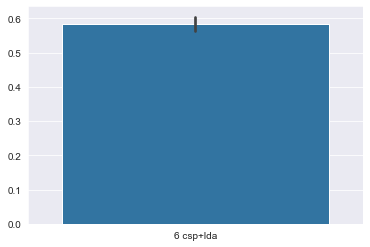

In [19]:
ax = sns.barplot(data= accuracy)

# Comparing to inline data

Text(0.5, 1.0, 'Comparaison des performances entre deux models')

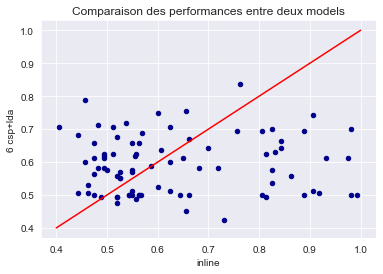

In [23]:
inline_accuracy = [84.375,55.625,98.125,51.25,51.25,65.625,47.5,56.225,66.25,82.5,51.875,60,65,49.375,75.625,49.375,45.625,82.5,98.125,83.125,56.875,88.75,51.875,93.125,81.25,65.625,45.625,48.125,52.5, 40.625, 52.5, 55.5, 62.5, 48.125, 90.625, 70, 47.5, 62.5, 81.25, 49.0625, 51.875, 51.875, 55, 56.25, 54.375, 54.375, 46.25, 56.625, 55, 52.5, 64.375, 88.75, 46.25, 47.5, 91.875, 99.375, 48.75, 66.25, 60, 56.25, 84.375, 90.625, 60, 50, 82.5, 58.75, 51.875, 55, 60.625, 55.625, 47.5, 44.375, 86.25, 68.125, 71.875, 80.625, 53.75, 55, 97.5, 49.375, 55, 49.375, 44.375, 76.25, 80.625, 62.5 ,73.125]

inline_order = ["A1"  ,"A2" ,"A3" ,"A4" ,"A5" ,"A6" ,"A7" ,"A8" ,"A9" ,"A10" ,"A11" ,"A12" ,"A13" ,"A14" ,"A15" ,"A16" ,"A17" ,"A18" ,"A19" ,"A20" ,"A21" ,"A22" ,"A23" ,"A24" ,"A25" ,"A26" ,"A27" ,"A28" ,"A29" ,"A30" ,"A31" ,"A32" ,"A33" ,"A34" ,"A35" ,"A36" ,"A37" ,"A38" ,"A39" ,"A40" ,"A41" ,"A42" ,"A43" ,"A44" ,"A45" ,"A46" ,"A47" ,"A48" ,"A49" ,"A50" ,"A51" ,"A52" ,"A53" ,"A54" ,"A55" ,"A56" ,"A57" ,"A58" ,"A59" ,"A60" ,"B61" ,"B62" ,"B63" ,"B64" ,"B65" ,"B66" ,"B67" ,"B68" ,"B69" ,"B70" ,"B71" ,"B72" ,"B73" ,"B74" ,"B75" ,"B76" ,"B77" ,"B78" ,"B79" ,"B80" ,"B81" ,"C82" ,"C83" ,"C84" ,"C85" ,"C86" ,"C87"]




inline_results = pd.DataFrame(inline_accuracy, inline_order, columns= ["inline"])
inline_results = inline_results/100

accuracy["inline"] = inline_results["inline"][accuracy.index]

ax1 = accuracy.plot.scatter(x='inline',y='6 csp+lda', c='DarkBlue')
ax1.plot([0.4,1],[0.4,1], c="red")
ax1.set_title("Comparaison des performances entre deux models")

In [112]:
from sklearn import linear_model

X = accuracy[["inline"]]
y = accuracy[["6 csp+lda"]]

# On fit le modele
model = linear_model.LinearRegression()
results = model.fit(X, y)




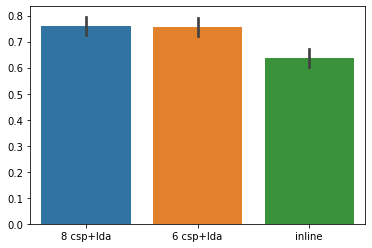

In [113]:
ax = sns.barplot(data= accuracy)

In [114]:
accuracy.to_csv("C:\\Users\Dtrocell\Documents\ML_exploratory\\right&leftvsrest.csv")

# Removing bad participants

Bad participants are defined by Pauline. It can be because of one specific channel is bad or others problem.

In [ ]:
bad_subjects = ["A3","A4","A5","A9","A11","A17","A27","A28","A29","A30","A31","A32","A37","A38","A41","A43","A46","A47","A49","A53","A60"]#,"B64","B67","B68","B69","B70","B78","B79","B81","C82","C83","C86"]

cleaned_accuracy =accuracy.drop(bad_subjects)
ax = sns.barplot(data= accuracy)

In [ ]:
cleaned_accuracy.mean()

# Bug et issues identifier dans le code
## Steps epoching

List start stop permet de gerer l'epoching avec overlap. Pour cela on utiliser la fonction np.arrange qui permet à partir d'un temps de début et de fin une liste de temps a prendre en compte.
ATTENTION a que la derniere valeur de list_stop soit <= 5 elle est determiné par tmax+overlap
Tu peux vérifier le comportement avec la cellule ci dessous

In [ ]:

tmin= 0.5
tmax = 5
length_epoch = 1
overlap = 1/16


list_start = np.arange(tmin, (tmax +overlap)- length_epoch, overlap)
list_stop = np.arange(tmin+length_epoch, (tmax+overlap), overlap)
print(list_start,list_stop, list_start-list_stop)

# Visualisation données filtres CSP

In [122]:
subject = "A1"
train_key = [subject+"_1", subject+"_2"]

steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
                    "tmin" : 0.25 , "tmax" : 5, "overlap" :1/16, "lenght": 1}

x_train, y_train = epoching(dic_data_train,train_key,steps_preprocess)

Used Annotations descriptions: ['769', '770', '800']
Used Annotations descriptions: ['769', '770', '800']


In [123]:
csp = CSP(n_components=6)
_ =csp.fit(x_train, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00029 (2.2e-16 eps * 27 dim * 4.8e+10  max singular value)
    Estimated rank (mag): 27
    MAG: rank 27 computed from 27 data channels with 0 projectors
Reducing data rank from 27 -> 27
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00033 (2.2e-16 eps * 27 dim * 5.5e+10  max singular value)
    Estimated rank (mag): 27
    MAG: rank 27 computed from 27 data channels with 0 projectors
Reducing data rank from 27 -> 27
Estimating covariance using EMPIRICAL
Done.


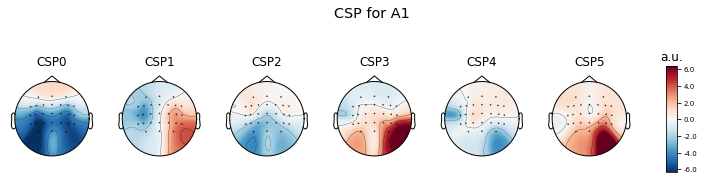

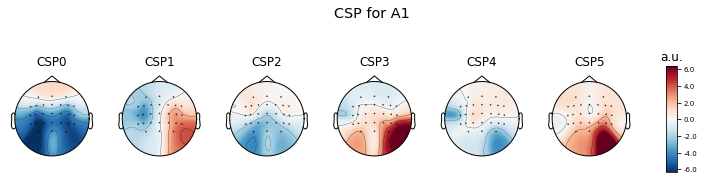

In [124]:
epoch = preprocess(dic_data_train["A10_1"], steps_preprocess)
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
epoch.set_montage(ten_twenty_montage)
csp.plot_patterns(epoch.info, title="CSP for %s " %subject)

Used Annotations descriptions: ['769', '770', '800']
Used Annotations descriptions: ['769', '770', '800']
Computing rank from data with rank=None
    Using tolerance 0.0003 (2.2e-16 eps * 27 dim * 5e+10  max singular value)
    Estimated rank (mag): 27
    MAG: rank 27 computed from 27 data channels with 0 projectors
Reducing data rank from 27 -> 27
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00029 (2.2e-16 eps * 27 dim * 4.8e+10  max singular value)
    Estimated rank (mag): 27
    MAG: rank 27 computed from 27 data channels with 0 projectors
Reducing data rank from 27 -> 27
Estimating covariance using EMPIRICAL
Done.


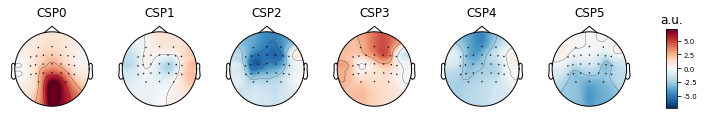

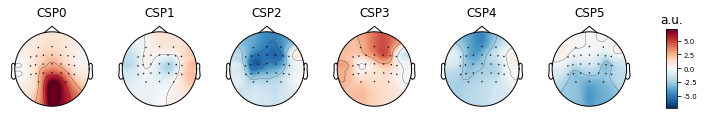

In [118]:
subject = "A10"
train_key = [subject+"_1", subject+"_2"]

steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
                    "tmin" : 0.25 , "tmax" : 5, "overlap" :1/16, "lenght": 1}

x_train, y_train = epoching(dic_data_train,train_key,steps_preprocess)

csp = CSP(n_components=6)
csp.fit(x_train, y_train)
epoch = preprocess(dic_data_train["A10_1"], steps_preprocess)
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
epoch.set_montage(ten_twenty_montage)
csp.plot_patterns(epoch.info)

In [3]:
left_acc = pd.read_csv("C:\\Users\dtrocell\Documents\ML\Big dataset\\results\shift_rest_vs_MI_left.csv" , index_col=0 )
right_acc = pd.read_csv("C:\\Users\dtrocell\Documents\ML\Big dataset\\results\shift_rest_vs_MI_right.csv" , index_col=0 )

In [4]:
left_right =pd.merge(left_acc, right_acc, right_index=True, left_index=True, suffixes=["_left", "_right"])

TypeError: boxplot() got an unexpected keyword argument 'figsize'

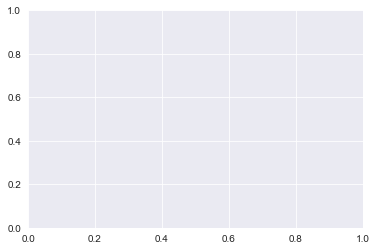

In [21]:
min = 0
max = 10
steps = 8
position = np.arange(min ,max ,(max -min)/steps)
sns.boxplot(data = left_right, width=0.7 , figsize= (10,10) , flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": "coral"},
            )

In [104]:
min = 0
max = 40
steps = 14
position = np.arange(min ,max ,(max -min)/steps)
# position =[0,7 ,1,8,2,9,3]
position =[0,7 ,1,8,2,9,3,10,4,11,5,12,6,13]
position =[0,2 ,4,6,8,10,12,1,3,5,7,9,11,13]
position =[0.2,2.2,4.2,6.2,8.2,10.2,12.2,0.8,2.8,4.8,6.8,8.8,10.8,12.8]

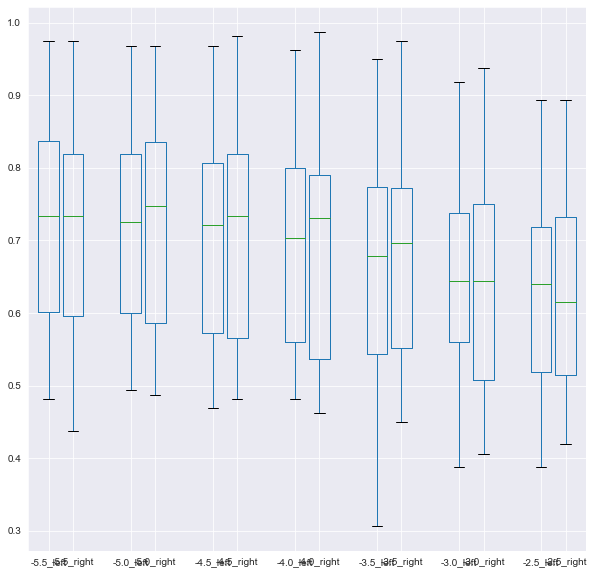

In [106]:
axes =  left_right.boxplot(figsize= (10,10) , positions= position
)


In [16]:
left_right

-5.5_left  -5.0_left  -4.5_left  -4.0_left  -3.5_left  -3.0_left  \
A1     0.88125    0.90000    0.88125    0.86875    0.84375    0.81250   
A10    0.73750    0.70000    0.70625    0.78125    0.75625    0.63750   
A11    0.90000    0.83750    0.88125    0.80000    0.73750    0.68750   
A12    0.68750    0.74375    0.70625    0.73125    0.60625    0.61875   
A13    0.81875    0.80000    0.76250    0.75625    0.71250    0.72500   
..         ...        ...        ...        ...        ...        ...   
C83    0.50000    0.50000    0.61875    0.58125    0.51250    0.74375   
C84    0.85000    0.85000    0.83125    0.79375    0.71250    0.64375   
C85    0.50000    0.50000    0.50000    0.50000    0.50000    0.50000   
C86    0.63125    0.61875    0.64375    0.64375    0.63750    0.67500   
C87    0.79375    0.76875    0.78750    0.83125    0.59375    0.60625   

     -2.5_left  -5.5_right  -5.0_right  -4.5_right  -4.0_right  -3.5_right  \
A1     0.79375     0.83750     0.88125     0.83750     0.78125     0.75625   
A10    0.63750     0.78750     0.81875     0.79375     0.79375     0.73125   
A11    0.66250     0.91875     0.89375     0.90000     0.85625     0.81875   
A12    0.60625     0.68750     0.71250     0.68125     0.64375     0.61875   
A13    0.62500     0.80625     0.78750     0.77500     0.78125     0.77500   
..         ...         ...         ...         ...         ...         ...   
C83    0.50000     0.51250     0.50000     0.50000     0.50000     0.50000   
C84    0.68125     0.83750     0.83125     0.84375     0.79375     0.78750   
C85    0.50000     0.50000     0.50000     0.50000     0.50000     0.50000   
C86    0.65625     0.71250     0.74375     0.76875     0.74375     0.76250   
C87    0.57500     0.80000     0.77500     0.83750     0.77500     0.73125   

     -3.0_right  -2.5_right  
A1      0.74375     0.80000  
A10     0.74375     0.70000  
A11     0.75000     0.74375  
A12     0.62500     0.55000  
A13     0.72500     0.70625  
..          ...         ...  
C83     0.50000     0.50000  
C84     0.76250     0.66250  
C85     0.50000     0.50000  
C86     0.75625     0.73750  
C87     0.71250     0.68750  

[86 rows x 14 columns]

In [51]:
len(position)

14

<AxesSubplot:>

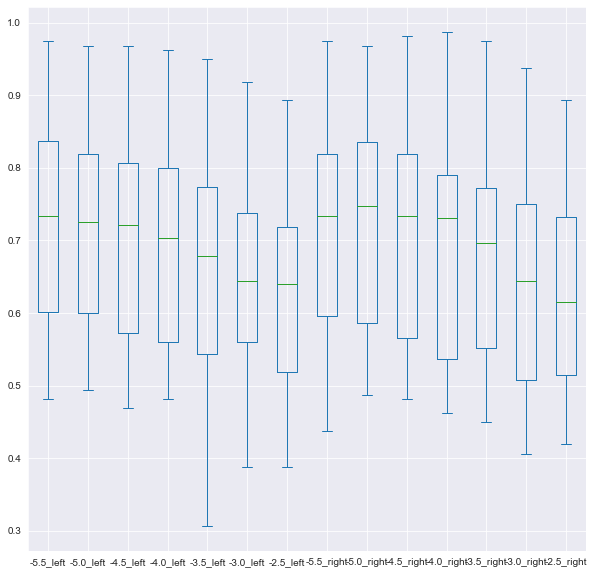

In [22]:
left_right.plot(kind= 'box', figsize= (10,10))
